<a href="https://colab.research.google.com/github/ottars/From-Component-Detection-to-Simulation-of-Analog-Circuits-Using-CNNs/blob/main/From_Component_Detection_to_Simulation_of_Analog_Circuits_Using_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecting discrete electronic components with CNN**

This project is essentially in two parts. The first part is training a model to classify 64x64 images of components. We have 15 different components to classify, and the model outputs the probabilities of each class. 

The second part of the code is implementing Sliding Windows to detect components in a circuit, using the previously trained CNN.

In [ ]:
#Import all packages and mount Google Drive to load data 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, models
from os import listdir
from os.path import isfile, join
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
import imutils
from sklearn.utils import shuffle
import matplotlib.patches as patches
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import each class from Drive and invert (dataset is inverted so this makes the background white and components black)
#These are 15 classes of components and we have to label them

resistors_data='/content/drive/MyDrive/CS230 final project/components/resistors_as_png'
onlyfiles = [ f for f in listdir(resistors_data) if isfile(join(resistors_data,f)) ]
resistors = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  resistors[n] = cv2.imread( join(resistors_data,onlyfiles[n]) )

resistors = np.array(resistors)
resistors = np.invert(resistors)
res = np.zeros((len(resistors),120,120,3))
for i in range(len(resistors)):
  res[i,:,:,:] = resistors[i]

voltmeter_data='/content/drive/MyDrive/CS230 final project/components/voltmeter_as_png'
onlyfiles = [ f for f in listdir(voltmeter_data) if isfile(join(voltmeter_data,f)) ]
voltmeters = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  voltmeters[n] = cv2.imread( join(voltmeter_data,onlyfiles[n]) )

voltmeters = np.array(voltmeters)
voltmeters = np.invert(voltmeters)
voltm = np.zeros((len(voltmeters),120,120,3))
for i in range(len(voltmeters)):
  voltm[i,:,:,:] = voltmeters[i]

inductor_data='/content/drive/MyDrive/CS230 final project/components/inductors_as_png'
onlyfiles = [ f for f in listdir(inductor_data) if isfile(join(inductor_data,f)) ]
inductors = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  inductors[n] = cv2.imread( join(inductor_data,onlyfiles[n]) )

inductors = np.array(inductors)
inductors = np.invert(inductors)
ind = np.zeros((len(inductors),120,120,3))
for i in range(len(inductors)):
  ind[i,:,:,:] = inductors[i]

ground2_data='/content/drive/MyDrive/CS230 final project/components/gnd2_as_png'
onlyfiles = [ f for f in listdir(ground2_data) if isfile(join(ground2_data,f)) ]
ground2 = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  ground2[n] = cv2.imread( join(ground2_data,onlyfiles[n]) )

ground2 = np.array(ground2)
ground2 = np.invert(ground2)
gnd2 = np.zeros((len(ground2),120,120,3))
for i in range(len(ground2)):
  gnd2[i,:,:,:] = ground2[i]

ground1_data='/content/drive/MyDrive/CS230 final project/components/gn1_as_png'
onlyfiles = [ f for f in listdir(ground1_data) if isfile(join(ground1_data,f)) ]
ground1 = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  ground1[n] = cv2.imread( join(ground1_data,onlyfiles[n]) )

ground1 = np.array(ground1)
ground1 = np.invert(ground1)
gnd1 = np.zeros((len(ground1),120,120,3))
for i in range(len(ground1)):
  gnd1[i,:,:,:] = ground1[i]

diode_data='/content/drive/MyDrive/CS230 final project/components/diode_as_png'
onlyfiles = [ f for f in listdir(diode_data) if isfile(join(diode_data,f)) ]
diodes = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  diodes[n] = cv2.imread( join(diode_data,onlyfiles[n]) )

diodes = np.array(diodes)
diodes = np.invert(diodes)
dio = np.zeros((len(diodes),120,120,3))
for i in range(len(diodes)):
  dio[i,:,:,:] = diodes[i]

depvolt_data='/content/drive/MyDrive/CS230 final project/components/dep_volt_as_png'
onlyfiles = [ f for f in listdir(depvolt_data) if isfile(join(depvolt_data,f)) ]
depvolts = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  depvolts[n] = cv2.imread( join(depvolt_data,onlyfiles[n]) )

depvolts = np.array(depvolts)
depvolts = np.invert(depvolts)
dpv = np.zeros((len(depvolts),120,120,3))
for i in range(len(depvolts)):
  dpv[i,:,:,:] = depvolts[i]

depcurr_data='/content/drive/MyDrive/CS230 final project/components/dep_curr_as_png'
onlyfiles = [ f for f in listdir(depcurr_data) if isfile(join(depcurr_data,f)) ]
depcurrs = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  depcurrs[n] = cv2.imread( join(depcurr_data,onlyfiles[n]) )

depcurrs = np.array(depcurrs)
depcurrs = np.invert(depcurrs)
dpc = np.zeros((len(depcurrs),120,120,3))
for i in range(len(depcurrs)):
  dpc[i,:,:,:] = depcurrs[i]

dcvolt1_data='/content/drive/MyDrive/CS230 final project/components/dc_voltage_as_png'
onlyfiles = [ f for f in listdir(dcvolt1_data) if isfile(join(dcvolt1_data,f)) ]
dcvolts1 = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  dcvolts1[n] = cv2.imread( join(dcvolt1_data,onlyfiles[n]) )

dcvolts1 = np.array(dcvolts1)
dcvolts1 = np.invert(dcvolts1)
dcv1 = np.zeros((len(dcvolts1),120,120,3))
for i in range(len(dcvolts1)):
  dcv1[i,:,:,:] = dcvolts1[i]

dcvolt2_data='/content/drive/MyDrive/CS230 final project/components/dc_volt2_as_png'
onlyfiles = [ f for f in listdir(dcvolt2_data) if isfile(join(dcvolt2_data,f)) ]
dcvolts2 = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  dcvolts2[n] = cv2.imread( join(dcvolt2_data,onlyfiles[n]) )

dcvolts2 = np.array(dcvolts2)
dcvolts2 = np.invert(dcvolts2)
dcv2 = np.zeros((len(dcvolts2),120,120,3))
for i in range(len(dcvolts2)):
  dcv2[i,:,:,:] = dcvolts2[i]

currsc_data='/content/drive/MyDrive/CS230 final project/components/curr_sc_as_png'
onlyfiles = [ f for f in listdir(currsc_data) if isfile(join(currsc_data,f)) ]
currsc = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  currsc[n] = cv2.imread( join(currsc_data,onlyfiles[n]) )

currsc = np.array(currsc)
currsc = np.invert(currsc)
c_source = np.zeros((len(currsc),120,120,3))
for i in range(len(currsc)):
  c_source[i,:,:,:] = currsc[i]

caps_data='/content/drive/MyDrive/CS230 final project/components/capacitors_as_png'
onlyfiles = [ f for f in listdir(caps_data) if isfile(join(caps_data,f)) ]
capacitors = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  capacitors[n] = cv2.imread( join(caps_data,onlyfiles[n]) )

capacitors = np.array(capacitors)
capacitors = np.invert(capacitors)
caps = np.zeros((len(capacitors),120,120,3))
for i in range(len(capacitors)):
  caps[i,:,:,:] = capacitors[i]

battery_data='/content/drive/MyDrive/CS230 final project/components/battery_as_png'
onlyfiles = [ f for f in listdir(battery_data) if isfile(join(battery_data,f)) ]
batterys = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  batterys[n] = cv2.imread( join(battery_data,onlyfiles[n]) )

batterys = np.array(batterys)
batterys = np.invert(batterys)
bats = np.zeros((len(batterys),120,120,3))
for i in range(len(batterys)):
  bats[i,:,:,:] = batterys[i]

ammeter_data='/content/drive/MyDrive/CS230 final project/components/ammeter_as_png'
onlyfiles = [ f for f in listdir(ammeter_data) if isfile(join(ammeter_data,f)) ]
ammeters = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  ammeters[n] = cv2.imread( join(ammeter_data,onlyfiles[n]) )

ammeters = np.array(ammeters)
ammeters = np.invert(ammeters)
ams = np.zeros((len(ammeters),120,120,3))
for i in range(len(ammeters)):
  ams[i,:,:,:] = ammeters[i]

wires_data='/content/drive/MyDrive/CS230 final project/components/wires_as_png'
onlyfiles = [ f for f in listdir(wires_data) if isfile(join(wires_data,f)) ]
wires = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  wires[n] = cv2.imread( join(wires_data,onlyfiles[n]) )

wires1 = np.array(wires)
wires = np.zeros((len(wires1),64,64,3))
for i in range(len(wires1)):
  wires[i,:,:,:] = wires1[i]

In [ ]:
#Create labels - ints from 1 to 15
res_labels = np.ones((len(res),1)) #1 - resistors
voltm_labels = 2*np.ones((len(voltm),1)) #2 - voltmeters
ind_labels = 3*np.ones((len(ind),1)) #3 - inductors
gnd2_labels = 4*np.ones((len(gnd2),1)) #4 - ground 2
gnd1_labels = 5*np.ones((len(gnd1),1)) #5 - ground 1
dio_labels = 6*np.ones((len(dio),1)) #6 - diode
dpv_labels = 7*np.ones((len(dpv),1)) #7 - dependent voltage source
dpc_labels = 8*np.ones((len(dpc),1)) #8 - dependent current source
dcv1_labels = 9*np.ones((len(dcv1),1)) #9 - dc voltage source 1
dcv2_labels = 10*np.ones((len(dcv2),1)) #10 - dc voltage source 2
c_source_labels = 11*np.ones((len(c_source),1)) #11 - current source
caps_labels = 12*np.ones((len(caps),1)) #12 - capacitors
bats_labels = 13*np.ones((len(bats),1)) #13 - battery
ams_labels = 14*np.ones((len(ams),1)) #14 - ammeter
wire_labels = 15*np.ones((len(wires),1)) #15 - wires

In [ ]:
#Construct dataset with labels
xdata = np.concatenate((res,voltm,ind,gnd2,gnd1,dio,dpv,dpc,dcv1,dcv2,c_source,caps,bats,ams))
#Shape of x: (2761,120,120,3) - (# of examples, n, n, channels)
ydata = np.concatenate((res_labels,voltm_labels,ind_labels,gnd2_labels,gnd1_labels,dio_labels,dpv_labels))
ydata = np.concatenate((ydata,dpc_labels,dcv1_labels,dcv2_labels,c_source_labels,caps_labels,bats_labels,ams_labels))
#Shape of y: (2761,1)

#Note: We add the wire images later because those have already been scaled

In [71]:
#Create two functions to process the data

#This function makes the contrast of the lines sharper by eliminating gray pixels
def BW(images):
  for i in range(images.shape[0]):
    for j in range(images.shape[1]):
      for k in range(images.shape[2]):
        if images[i,j,k] >200:
          images[i,j,k] = 255.0
        else:
          images[i,j,k]=0.0

#This function does it for a single image
def BW2(image):
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if image[i,j] > 180:
        image[i,j] = 255.0
      else:
        image[i,j]=0


#This function reduces channels from 3 to 1 (grayscale), since we don't need colors
def rgb2gray(rgb):
  r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

#This function does it for a single image
def rgb2gray2(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray


In [ ]:
#Normalize data and reduce dimensions from 120x120 to 64x64, using the functions created above
#We process the wire images separately because they are already 64x64

wires_norm = rgb2gray(wires)
xdata_norm = rgb2gray(xdata)
xdata = resize(xdata_norm, (len(xdata_norm),64,64))
BW(xdata)
BW(wires_norm)
xdata = xdata/255
wires = wires_norm/255

In [ ]:
#Add 200 empty images to the dataset and label them with 0
#Each class contains ca. 200 images so this is in proportion
#Add the images of the wires as well

negative = np.ones((200,64,64))
negative[:] = 0.9999

xdata = np.concatenate((negative,xdata))
xdata = np.concatenate((xdata,wires))
ydata = np.concatenate((np.zeros((200,1)),ydata))
ydata = np.concatenate((ydata,wire_labels))

In [ ]:
#Now we augment the data
#Initialize augmented dataset as 4x the size of the original
#We rotate each image three times by 90 degrees

xaugment = np.zeros((4*xdata.shape[0],xdata.shape[1],xdata.shape[2]))
yaugment = np.zeros((4*len(ydata),1))
for i in range(0,len(xdata)):
  j = 4*i
  test = xdata[i]
  xaugment[j] = test
  yaugment[j] = ydata[i]
  ninety = imutils.rotate(test, angle = 90)
  xaugment[j+1] = ninety
  yaugment[j+1] = ydata[i]
  oneeighty = imutils.rotate(ninety, angle=90)
  xaugment[j+2] = oneeighty
  yaugment[j+2] = ydata[i]
  twoseventy = imutils.rotate(oneeighty, angle=90)
  xaugment[j+3] = twoseventy
  yaugment[j+3] = ydata[i]

#Make sure to adjust the labels accordingly
for i in range(0,len(ydata)):
  j = 4*i
  yaugment[j] =  ydata[i]
  yaugment[j+1] = ydata[i]
  yaugment[j+2] = ydata[i]
  yaugment[j+3] = ydata[i]

In [ ]:
#We now have 12,656 training examples
#Shuffle the data
x_all, y_all = shuffle(xaugment,yaugment, random_state=0)

#Split into train/dev/test
#Approximately 70/15/15
xtrain = x_all[0:8860,:,:]
ytrain_int = y_all[0:8860,:]
xdev = x_all[8861:10757,:,:]
ydev_int = y_all[8861:10757,:]
xtest = x_all[10758:len(x_all),:,:]
ytest_int = y_all[10758:len(y_all),:]

#Let's encode the labels
#Note that while we have 15 categories of components, we added a class for "Nothing" so total number is 16
num_category = 16

#We convert each class label to a binary class matrix (One-Hot encoding)
ytrain = keras.utils.to_categorical(ytrain_int, num_category)
ytest = keras.utils.to_categorical(ytest_int, num_category)
ydev = keras.utils.to_categorical(ydev_int, num_category)

#Define a dictionary for the labels.
dictionary = ["Nothing","Resistor", "Voltmeter", "Inductor", "Ground2", "Ground1", "Diode", "Dependent voltage source", "Dependent current source", "DC voltage source1", "DC voltage source2", "Current source", "Capacitor","Battery", "Ammeter","Wire"]

In [ ]:
#Now we create the model. This is a modified version of a network by Sambit Mahapatra (A simple 2D CNN for MNIST digit recognition)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding ='same', activation='relu', input_shape=(64, 64, 1)))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),padding ='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16, activation = 'softmax'))

In [ ]:
#Compile the model: We use Adam optimizer and a categorical cross-entropy loss since we are outputting classification
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [50]:
#Train the model. Note this can take some time, and validation accuracy will plateu at approx. 94% after 40-50 epochs

history = model.fit(xtrain, ytrain_int, epochs=50, batch_size = 32, validation_data=[xdev,ydev_int])

Epoch 1/50
277/277 [==============================] - 124s 346ms/step - loss: 2.0843 - accuracy: 0.2924 - val_loss: 1.4096 - val_accuracy: 0.5765
Epoch 2/50
277/277 [==============================] - 95s 343ms/step - loss: 1.1008 - accuracy: 0.5742 - val_loss: 1.0207 - val_accuracy: 0.6519
Epoch 3/50
277/277 [==============================] - 91s 328ms/step - loss: 0.8121 - accuracy: 0.6649 - val_loss: 0.7828 - val_accuracy: 0.7136
Epoch 4/50
277/277 [==============================] - 90s 326ms/step - loss: 0.6964 - accuracy: 0.7139 - val_loss: 0.6304 - val_accuracy: 0.7753
Epoch 5/50
277/277 [==============================] - 95s 342ms/step - loss: 0.5855 - accuracy: 0.7611 - val_loss: 0.5456 - val_accuracy: 0.8112
Epoch 6/50
277/277 [==============================] - 93s 335ms/step - loss: 0.5111 - accuracy: 0.7914 - val_loss: 0.4947 - val_accuracy: 0.8286
Epoch 7/50
277/277 [==============================] - 92s 333ms/step - loss: 0.4391 - accuracy: 0.8174 - val_loss: 0.4876 - val_a

In [51]:
#A summary of the model:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 dropout_15 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                 

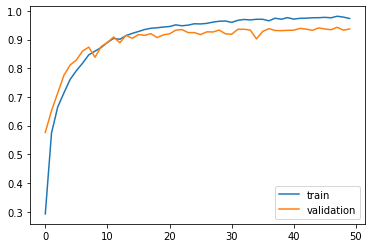

In [52]:
#Let's take a look at the learning curves.
#Accuracy:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

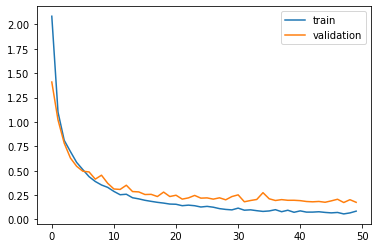

In [53]:
#Loss:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [55]:
#Evaluate the testing accuracy

mse_test = model.evaluate(xtest, ytest_int)

60/60 [==============================] - 8s 133ms/step - loss: 0.1468 - accuracy: 0.9478


In [56]:
#Error analysis:
#This helps us identify and analyze common mistakes made by the model
dictionary = ["Nothing","Resistor", "Voltmeter", "Inductor", "Ground2", "Ground1", "Diode", "Dependent voltage source", "Dependent current source", "DC voltage source1", "DC voltage source2", "Current source", "Capacitor","Battery", "Ammeter","Wire"]
predictions = model.predict(xtest)

preds = np.argmax(predictions, axis = -1)
correct = np.argmax(ytest, axis = -1)

wrong_indices = []
for i in range(len(preds)):
  if preds[i] != correct[i]:
    wrong_indices.append(i)

wrong_indices = np.array(wrong_indices)

60/60 [==============================] - 7s 113ms/step


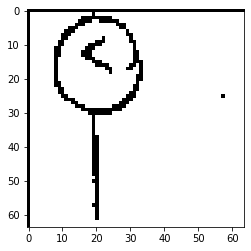

Predicted: Dependent voltage source
Correct: Voltmeter
6


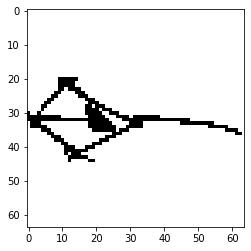

Predicted: Dependent voltage source
Correct: Dependent current source
12


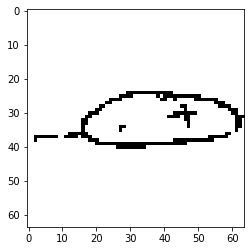

Predicted: Current source
Correct: DC voltage source1
25


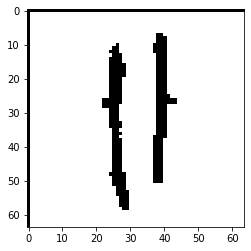

Predicted: Capacitor
Correct: DC voltage source2
32


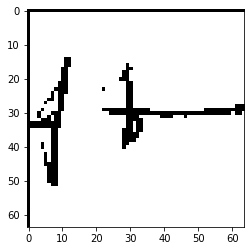

Predicted: Capacitor
Correct: DC voltage source2
33


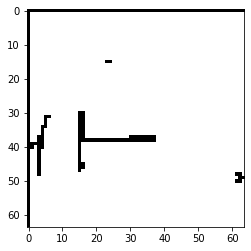

Predicted: DC voltage source2
Correct: Capacitor
41


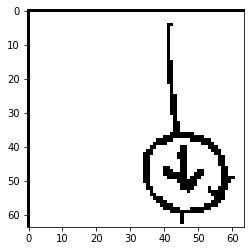

Predicted: Ammeter
Correct: Current source
54


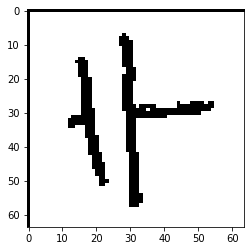

Predicted: DC voltage source2
Correct: Capacitor
64


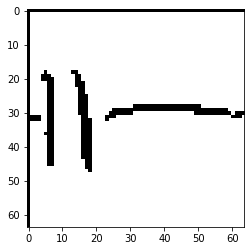

Predicted: DC voltage source2
Correct: Capacitor
82


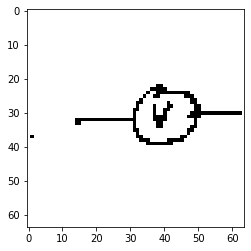

Predicted: DC voltage source1
Correct: Voltmeter
87


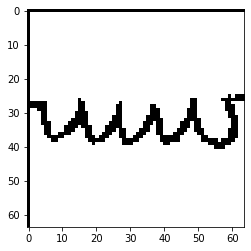

Predicted: Resistor
Correct: Inductor
97


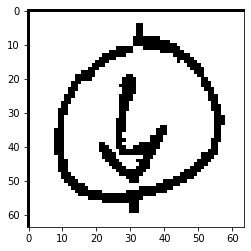

Predicted: Ammeter
Correct: Current source
100


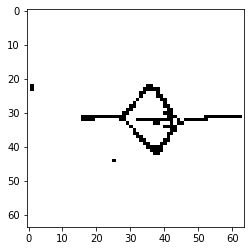

Predicted: Dependent voltage source
Correct: Dependent current source
107


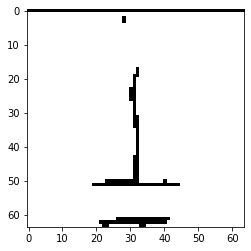

Predicted: DC voltage source2
Correct: Capacitor
112


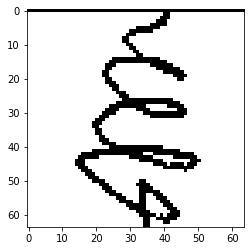

Predicted: Resistor
Correct: Inductor
117


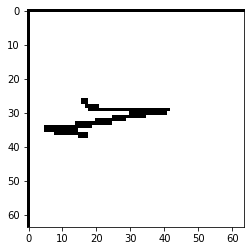

Predicted: DC voltage source2
Correct: Resistor
154


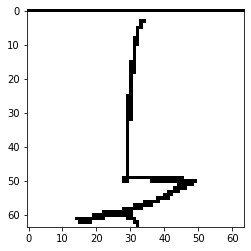

Predicted: DC voltage source2
Correct: Resistor
165


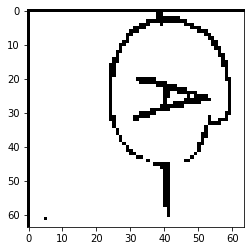

Predicted: Current source
Correct: Ammeter
166


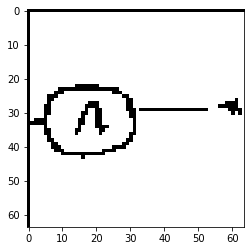

Predicted: Ammeter
Correct: Voltmeter
242


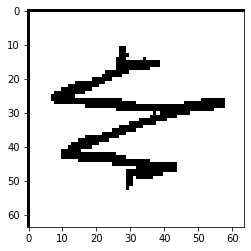

Predicted: Battery
Correct: Resistor
251


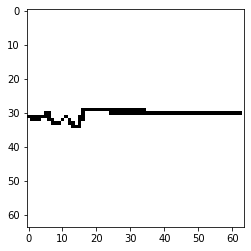

Predicted: Wire
Correct: Resistor
253


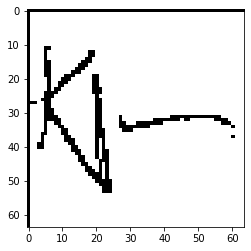

Predicted: Dependent voltage source
Correct: Diode
267


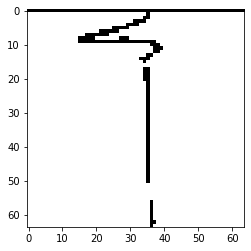

Predicted: DC voltage source2
Correct: Resistor
277


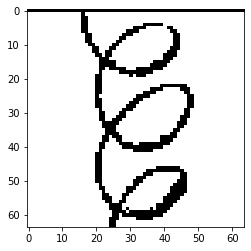

Predicted: Voltmeter
Correct: Inductor
280


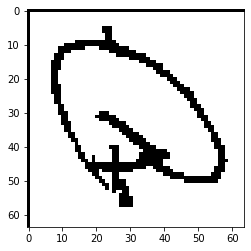

Predicted: Voltmeter
Correct: Ammeter
287


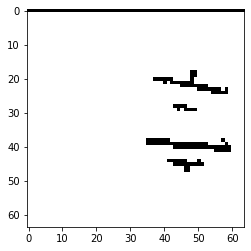

Predicted: Capacitor
Correct: Battery
340


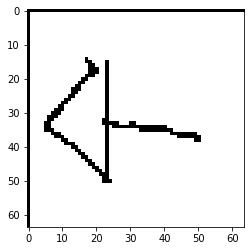

Predicted: Dependent voltage source
Correct: Ground2
358


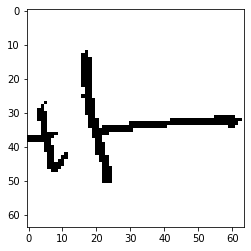

Predicted: Capacitor
Correct: DC voltage source2
383


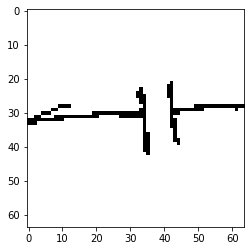

Predicted: DC voltage source2
Correct: Capacitor
394


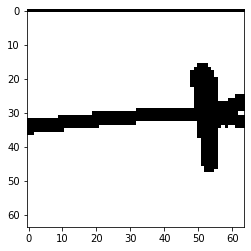

Predicted: DC voltage source2
Correct: Wire
395


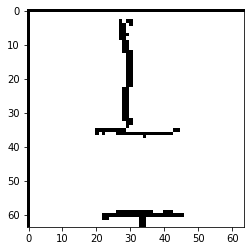

Predicted: DC voltage source2
Correct: Capacitor
417


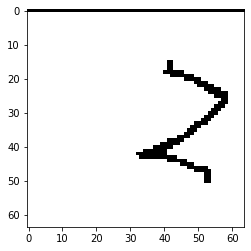

Predicted: Dependent voltage source
Correct: Resistor
429


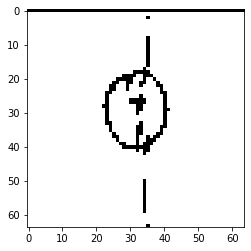

Predicted: Current source
Correct: DC voltage source1
443


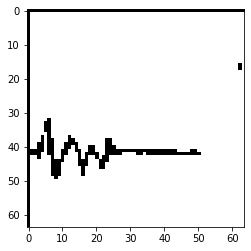

Predicted: Inductor
Correct: Resistor
475


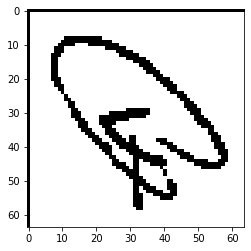

Predicted: Ammeter
Correct: Voltmeter
486


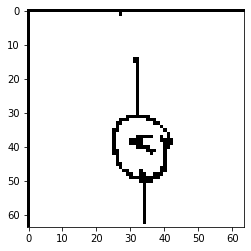

Predicted: Current source
Correct: Voltmeter
518


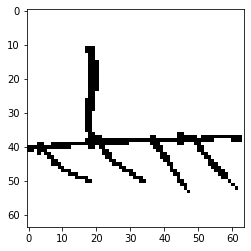

Predicted: Ground2
Correct: Ground1
529


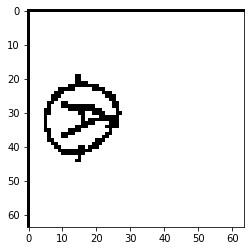

Predicted: Current source
Correct: Ammeter
544


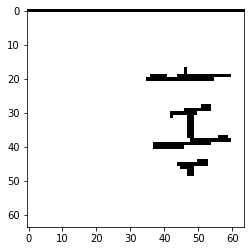

Predicted: Capacitor
Correct: Battery
569


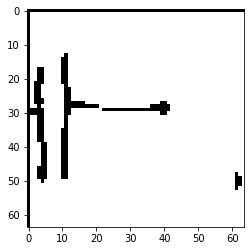

Predicted: DC voltage source2
Correct: Capacitor
584


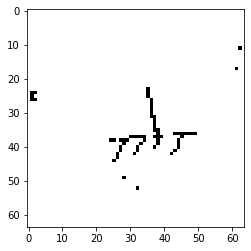

Predicted: DC voltage source1
Correct: Ground1
650


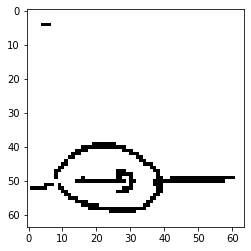

Predicted: DC voltage source1
Correct: Current source
654


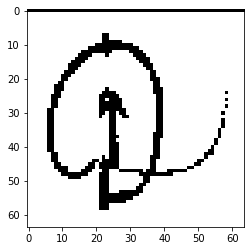

Predicted: Ammeter
Correct: Current source
656


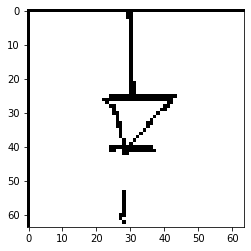

Predicted: Capacitor
Correct: Diode
663


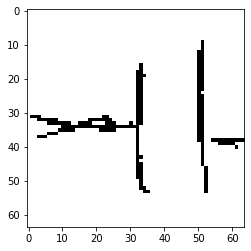

Predicted: Battery
Correct: Capacitor
677


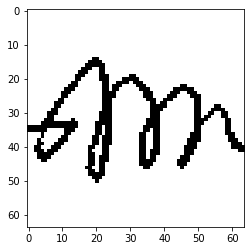

Predicted: Resistor
Correct: Inductor
696


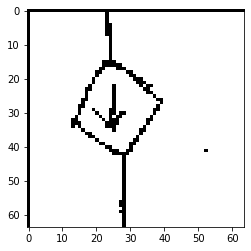

Predicted: Dependent voltage source
Correct: Dependent current source
702


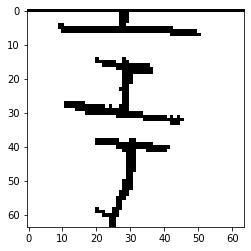

Predicted: DC voltage source2
Correct: Battery
709


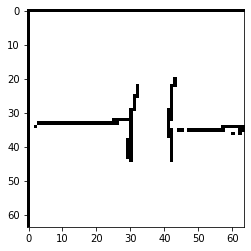

Predicted: DC voltage source2
Correct: Capacitor
737


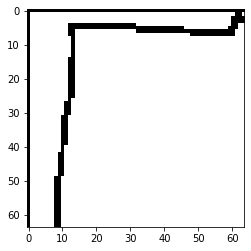

Predicted: Capacitor
Correct: Wire
756


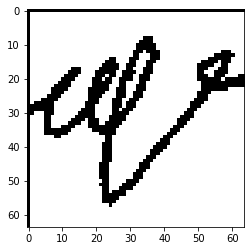

Predicted: Dependent current source
Correct: Inductor
769


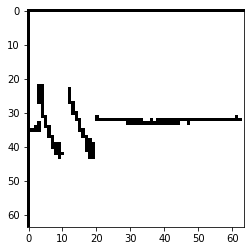

Predicted: DC voltage source2
Correct: Capacitor
772


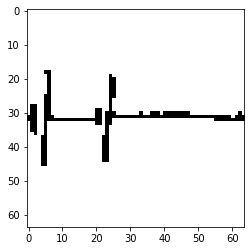

Predicted: Capacitor
Correct: Battery
804


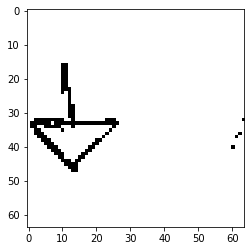

Predicted: DC voltage source1
Correct: Ground2
818


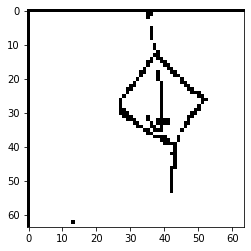

Predicted: Dependent voltage source
Correct: Dependent current source
862


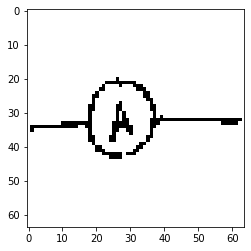

Predicted: Voltmeter
Correct: Ammeter
889


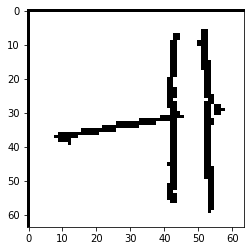

Predicted: DC voltage source2
Correct: Capacitor
905


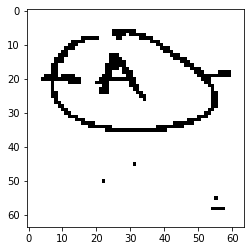

Predicted: Current source
Correct: Ammeter
924


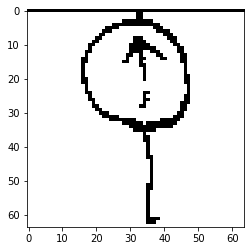

Predicted: Voltmeter
Correct: Current source
949


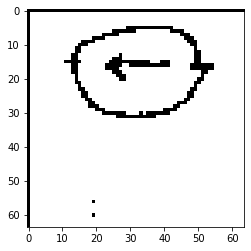

Predicted: DC voltage source1
Correct: Current source
1009


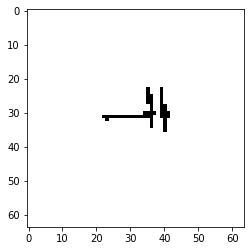

Predicted: DC voltage source2
Correct: Capacitor
1027


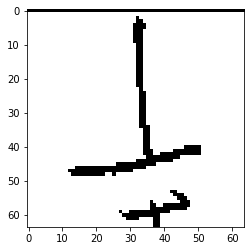

Predicted: Capacitor
Correct: DC voltage source2
1028


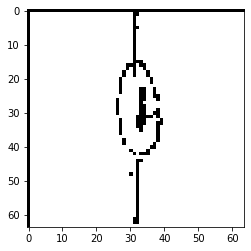

Predicted: DC voltage source1
Correct: Current source
1056


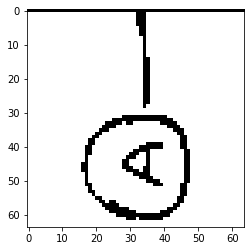

Predicted: Voltmeter
Correct: Ammeter
1074


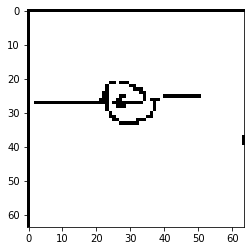

Predicted: Voltmeter
Correct: Current source
1106


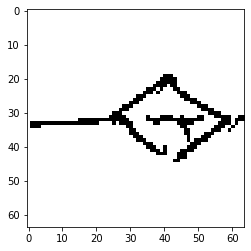

Predicted: Dependent current source
Correct: Dependent voltage source
1119


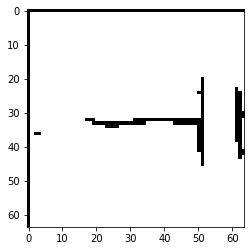

Predicted: DC voltage source2
Correct: Capacitor
1147


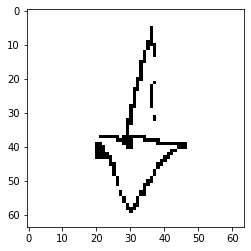

Predicted: Dependent voltage source
Correct: Ground2
1172


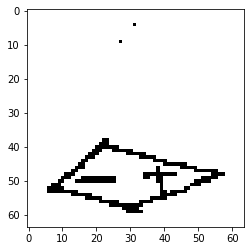

Predicted: Diode
Correct: Dependent voltage source
1197


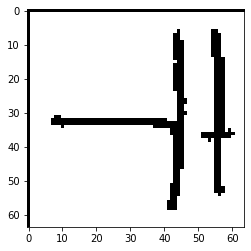

Predicted: DC voltage source2
Correct: Capacitor
1207


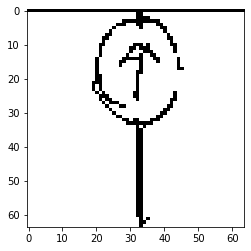

Predicted: Voltmeter
Correct: Current source
1215


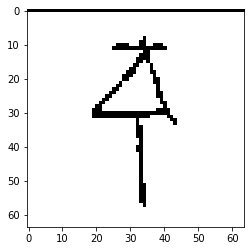

Predicted: Ground2
Correct: Diode
1235


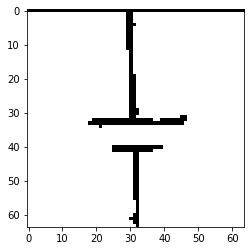

Predicted: Capacitor
Correct: DC voltage source2
1263


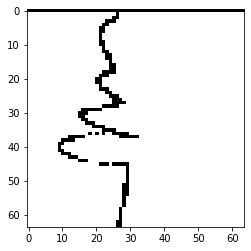

Predicted: Resistor
Correct: Inductor
1293


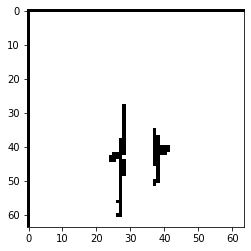

Predicted: Capacitor
Correct: DC voltage source2
1311


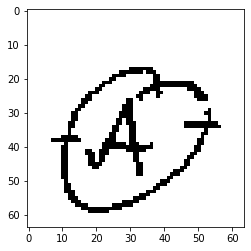

Predicted: DC voltage source1
Correct: Ammeter
1319


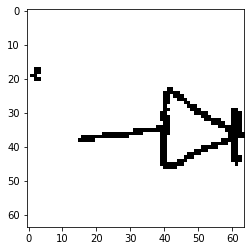

Predicted: Ground2
Correct: Diode
1335


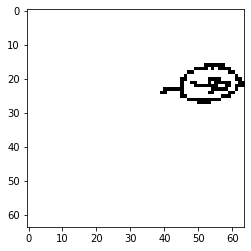

Predicted: Voltmeter
Correct: Current source
1341


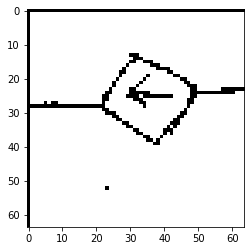

Predicted: Dependent voltage source
Correct: Dependent current source
1364


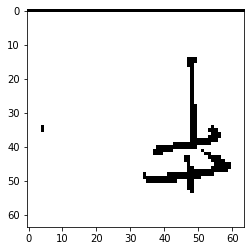

Predicted: DC voltage source2
Correct: Capacitor
1365


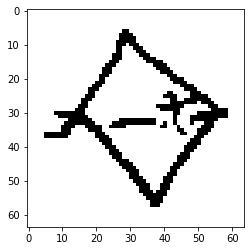

Predicted: Dependent current source
Correct: Dependent voltage source
1371


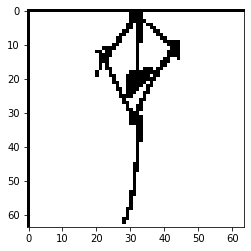

Predicted: Dependent voltage source
Correct: Dependent current source
1373


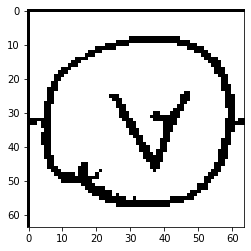

Predicted: Voltmeter
Correct: Ammeter
1378


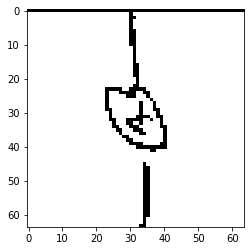

Predicted: Current source
Correct: Ammeter
1386


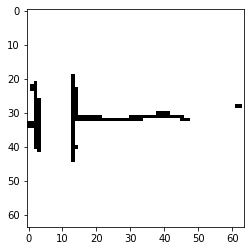

Predicted: DC voltage source2
Correct: Capacitor
1462


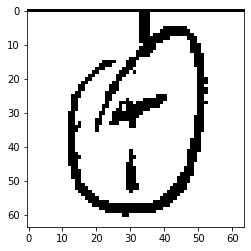

Predicted: Ammeter
Correct: DC voltage source1
1493


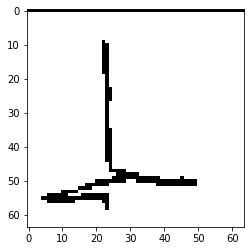

Predicted: Capacitor
Correct: Resistor
1519


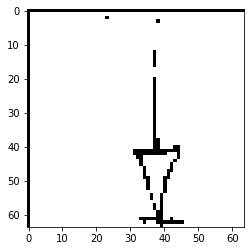

Predicted: DC voltage source2
Correct: Diode
1540


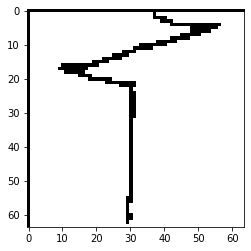

Predicted: DC voltage source2
Correct: Resistor
1600


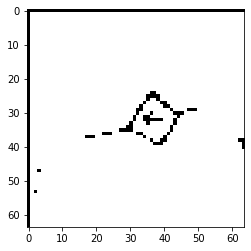

Predicted: Dependent voltage source
Correct: Dependent current source
1601


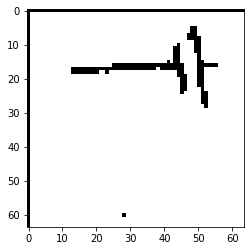

Predicted: Capacitor
Correct: DC voltage source2
1618


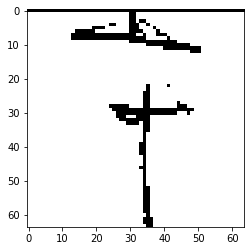

Predicted: Capacitor
Correct: DC voltage source2
1639


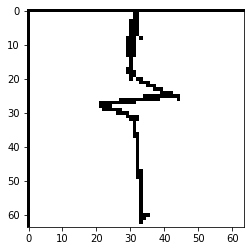

Predicted: Diode
Correct: Resistor
1651


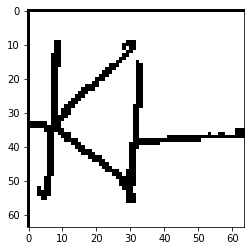

Predicted: Ground1
Correct: Diode
1709


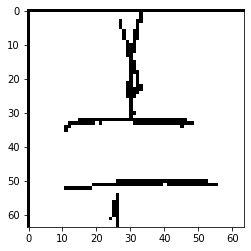

Predicted: DC voltage source2
Correct: Capacitor
1762


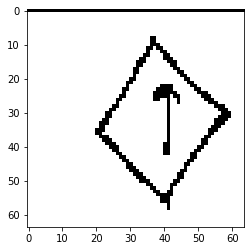

Predicted: Dependent voltage source
Correct: Dependent current source
1777


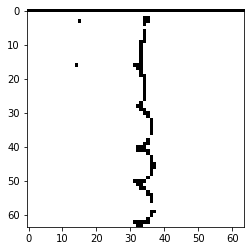

Predicted: DC voltage source2
Correct: Inductor
1804


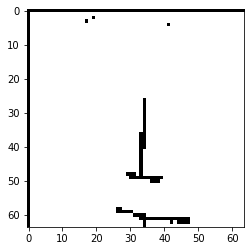

Predicted: Capacitor
Correct: DC voltage source2
1851


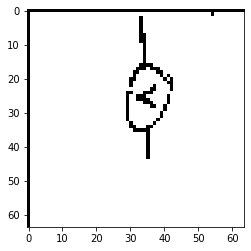

Predicted: Current source
Correct: Voltmeter
1874


In [57]:
#Let's look at mislabeled images.

for i in range(len(wrong_indices)):
    plt.imshow(xtest[wrong_indices[i]], cmap='gray')
    plt.show()
    print('Predicted:',dictionary[preds[wrong_indices[i]]])
    print('Correct:',dictionary[correct[wrong_indices[i]]])
    print(wrong_indices[i])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(ytest_int, preds)

In [59]:
#Function to compute confusion matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, dictionary, labels, ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=dictionary, columns=dictionary)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.show()

60/60 [==============================] - 4s 64ms/step


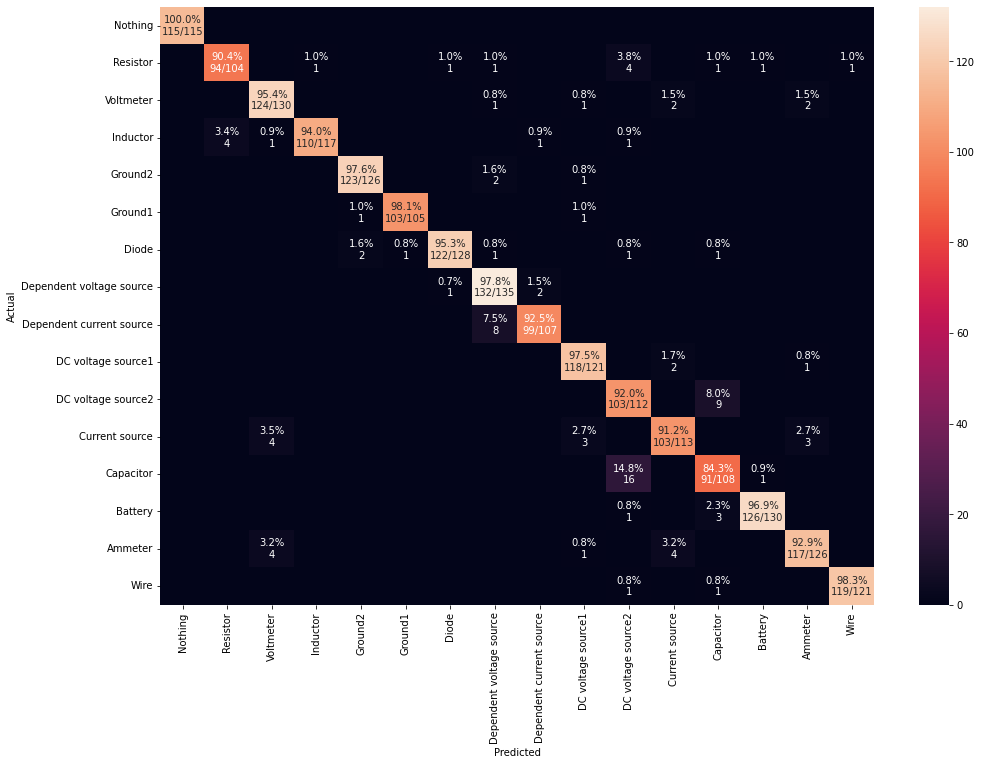

In [60]:
#Let's look at the confusion matrix
predictions = model.predict(xtest)
cm_analysis(ytest_int.reshape(len(ytest_int),).astype('int'), np.argmax(predictions,axis = 1).reshape(len(predictions),),dictionary, labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], figsize = (16,11))

**Component detection using Sliding Windows**

Now we want to identify components in a circuit, using the model we have trained. We will use the Sliding Window method, predicting the content of each window in the image, but first we need to define a few functions that we will call on in the Sliding Windows function.

In [61]:
#We define a function that calculates the Intersection-over-union coefficient of two boxes. 
#We use this function to perform non-max suppression

def iou(box1,box2):
  #Get the coordinates of the two boxes
  box1_x1,box1_y1,box1_x2,box1_y2 = box1[0],box1[1],box1[2],box1[3]
  box2_x1,box2_y1,box2_x2,box2_y2 = box2[0],box2[1],box2[2],box2[3]

  #Calculate the intersection area
  xi1 = max(box1_x1,box2_x1)
  yi1 = max(box1_y1,box2_y1)
  xi2 = min(box1_x2,box2_x2)
  yi2 = min(box1_y2,box2_y2)
  inter_width = xi2-xi1
  inter_height = yi2-yi1
  inter_area = max(inter_width,0)*max(inter_height,0)

  #Calculate the union area
  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area + box2_area - inter_area

  #The IOU is the ratio:
  iou = inter_area/union_area
  return iou

In [62]:
#This function performs non-max suppression. In the case of overlapping boxes, we want to choose the one with the highest probability.

def non_max_suppression(boxes,classes,iou_threshold):
  #Get the coordinates of each box in the image
  #We define the score of each box as the highest probability  
  x1 = np.zeros((len(boxes),1))
  x2 = np.zeros((len(boxes),1))
  y1 = np.zeros((len(boxes),1))
  y2 = np.zeros((len(boxes),1))
  score = np.zeros((len(boxes),1))
  for i in range(len(boxes)):
    x1[i],y1[i],x2[i],y2[i] = boxes[i][0],boxes[i][1],boxes[i][2],boxes[i][3]
    score[i] = np.max(classes[i])
  
  #Sort the boxes by probabilty, so the box with the highest score is at the top of the list.
  #To sort the boxes along with their scores and classes, we concatenate everything in an array and convert to a list.
  stuff = np.concatenate((boxes,classes,score),axis=1)
  stuff_list = stuff.tolist()
  max_score_first = sorted(stuff_list, key = lambda x: x[-1], reverse = True)
  max_score_first = np.array(max_score_first)

  #Now we can pick out the boxes and corresponding values from the sorted list.
  boxes = max_score_first[:,0:4]
  classes = max_score_first[:,4:21]
  scores = max_score_first[:,-1]

  #Initialize the indexes of the boxes that can be removed
  indexes_to_delete = []

  #We go down the list of boxes, beginning with the box with the highest score, and calculate the IOU with all the boxes below it in the list
  for i in range(len(boxes)-1):
    for k in range(i+1,len(boxes)):
      overlap = iou(boxes[i],boxes[k])
      if (overlap > iou_threshold):
        indexes_to_delete.append(k)
        break
  
  #Now we know which boxes can be removed, and we want to retain the correct classes so we concatente boxes and classes, then delete.
  stuff = np.concatenate((boxes,classes),axis=1)
  stuff = np.delete(stuff,indexes_to_delete,axis=0)

  #Pick out the boxes and corresponding classes 
  boxes = stuff[:,0:4]
  classes = stuff[:,4:]
  return boxes.astype("int"), classes

In [63]:
#This function makes it easier to print the images along with bounding boxes and classes

def drawBoxes(image,boxes,classes):
  fig, ax = plt.subplots()
  for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i,0], boxes[i,1]), boxes[i,2]-boxes[i,0], boxes[i,3]-boxes[i,1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(boxes[i,0],boxes[i,1],dictionary[np.argmax(classes[i])], fontsize = 8, color='r')
  ax.imshow(image,cmap = 'gray')
  plt.show()

In [64]:
#Now we can define the function that detects components in a circuit using a sliding window approach.

def sliding_window(image, parallel):
  #Initialize the lists to which we will add the appropriate boxes and corresponding classes
	boxes = []
	classes = []
	components = []

  #We try out three different sets of window and step sizes
	windows = [100, 120, 140]
	steps = [30, 40, 50]

	for i in range(3):
		stepSize = steps[i]
		windowSize = windows[i]
		for y in range(0, image.shape[0], stepSize):
			for x in range(0, image.shape[1], stepSize):
				if y + windowSize < image.shape[0]:
					if x + windowSize < image.shape[1]:

					  #Create the window
						sample = resize(image[y:y + windowSize, x:x + windowSize], (64,64)).reshape(1,64,64)
		 			
					  #Predict its contents
						prediction = model.predict(sample/255, verbose = 0)
		 
		 			  #We select the class with the highest probability
						found = dictionary[np.argmax(prediction)]

						if (found != "Nothing") and (found != "Wire") and (np.max(prediction) > 0.6) and (parallel == False or dictionary[np.argmax(prediction)] != "Capacitor" or (x < 600 and x>400)):
							boxes.append([x,y,x+windowSize,y+windowSize]) #(x1,y1,x2,y2)
							classes.append(prediction)
			
	boxes = np.array(boxes) 
	classes = np.array(classes).reshape(len(classes), len(dictionary))
	return boxes, classes

In [ ]:
#We test our method on a dataset of circuit images. We begin by uploading the images.

circuits_test='/content/drive/MyDrive/Colab Notebooks/CS 230/circuits_test_ultimate'
onlyfiles = [ f for f in listdir(circuits_test) if isfile(join(circuits_test,f)) ]
circuits = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  circuits[n] = cv2.imread( join(circuits_test,onlyfiles[n]) )
circuits_raw = np.array(circuits)

In [65]:
#We need to define a new function for the circuit images, since they are of different sizes.

def rgb2gray_3d(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

In [66]:
#We want the images to have one channel, so let's apply the function defined above.
#We also want to standardize the images so we can estimate appropriate window sizes.
#After using the resize function we apply the BW filter to increase the contrast.

def standardize(circuits_raw):
  circuits = np.zeros((len(circuits_raw),1000,1000))
  for i in range(len(circuits_raw)):
    circuits_raw[i] = rgb2gray_3d(circuits_raw[i])
    circuits_raw[i] = resize(circuits_raw[i],(1000,1000),mode = 'constant')
    circuits_raw[i].reshape(1,1000,1000)
    circuits[i] = circuits_raw[i]
  BW(circuits)
  return circuits

In [75]:
def standardize_single(image):
  new_image = rgb2gray2(image)
  new_image = resize(new_image, (1200,1200), mode = 'constant') #To standardize
  BW2(new_image)
  return new_image

In [ ]:
#Let's apply the function above to our dataset so we can evaluate the sliding windows method.

circuits = standardize(circuits_raw)

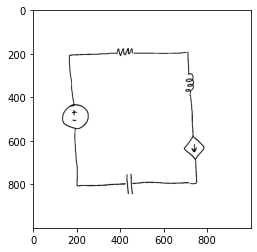

In [ ]:
#This method was designed to evaluate one image at a time, so let's look at one image from the dataset.

testphoto = circuits[24]
plt.imshow(testphoto,cmap="gray")

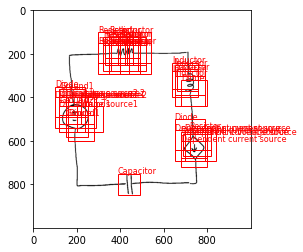

In [ ]:
#Let's see what our algorithm finds:

boxes, classes = sliding_window(testphoto,False)
drawBoxes(testphoto,boxes,classes)

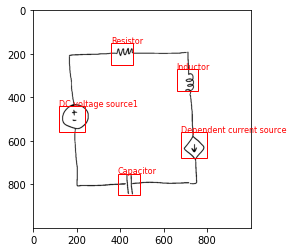

In [ ]:
#To clear overlapping boxes we apply non-max suppression:

boxes_new, classes_new = non_max_suppression(boxes,classes,0)
drawBoxes(testphoto,boxes_new,classes_new)

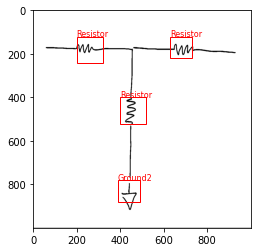

In [ ]:
boxes_new, classes_new = non_max_suppression(boxes_new,classes_new,0)
drawBoxes(testphoto,boxes_new,classes_new)

In [ ]:
#Results
#circuits[13] þarf að minnka dc source
indexes = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,24,25])
predicted_boxes = np.array([6,5,5,6,5,4,4,3,4,4,4,3,3,4,4,2,4,3,4,5,5,5,5])
correct_boxes = np.array([5,4,5,5,5,3,3,2,4,3,4,1,1,3,3,1,2,2,3,4,5,5,4])
resistors_total = 23
correct_resistors = 23
inductors_total = 15
inductors_correct = 13
DC_volt_total = 14
DC_volt_correct = 10
diode_total = 7
diode_correct = 5
capacitors_total = 13
capacitors_correct = 11
dep_current_total = 4
dep_current_correct = 1
dep_volt_total = 2
dep_volt_correct = 0
ground_total = 7
ground_correct = 7
curr_source_total = 4
curr_source_correct = 2
missed_components = 4


In [ ]:
sum(correct_boxes)/sum(predicted_boxes)

0.7938144329896907

Voila! We can now detect components in a circuit. 

**Simulating parallel circuits in HSPICE**

If we place certain criteria on the circuits, we can use this method to detect the components of a parallel circuit and output code that we can export directly into HSPICE to simulate the circuit.

In [96]:
#Sort boxes from left to right in order for component values to be assigned to the correct components.

def sortLtoR(boxes, classes):
  y1 = boxes[:,0]
  idxs = np.argsort(y1)
  boxes_new = boxes[idxs]
  classes_new = classes[idxs]
  return boxes_new, classes_new

In [86]:
#Assume only RCL circuits
#Assume classes and values correspond to the components from left to right.
def HSPICE(dictionary, CLASSES,  values):
  Rcounter = 1
  Ccounter = 1
  Lcounter = 1
  Vcounter = 1
  Icounter = 1
  code = "\n" #First line has to be blank
  for i in range(len(CLASSES)):
    componentType = dictionary[np.argmax(CLASSES[i])]
    print(componentType)
    if(componentType == "Resistor"):
      code += "R"+str(Rcounter)+" HIGH GND "+str(values[i])+"\n"
      Rcounter += 1
    elif(componentType == "Inductor"):
      code += "L"+str(Lcounter)+" HIGH GND "+str(values[i])+"\n"
      Lcounter += 1
    elif(componentType == "Capacitor"):
      code += "C"+str(Ccounter)+" HIGH GND "+str(values[i])+"\n"
      Ccounter += 1
    elif(componentType == "DC voltage source1" or componentType == "DC voltage source2" or componentType == "Battery"):
      code += "V"+str(Vcounter)+" HIGH GND "+"ac "+str(values[i])+"\n" #Assume Always AC source
      Vcounter += 1
    elif(componentType == "Current source"):
      code += "I"+str(Vcounter)+" HIGH GND "+"ac "+str(values[i])+"\n" #Assume Always AC source
      Icounter += 1
    else:
      return "Error!!! invalid component"
  code += ".option post brief nomod \n" #To 
  code += ".ac dec 100 1 10G \n" #default AC sweep
  code += ".end"
  return code

In [ ]:
#Test netlist generation
simImage = cv2.imread('/content/drive/MyDrive/CS230 final project/circuits_as_png/Otti26.png')
simImage = standardize_single(simImage)
boxesH, classesH = sliding_window(simImage,parallel = True)
boxes_newH, classes_newH = non_max_suppression(boxesH,classesH, 0)

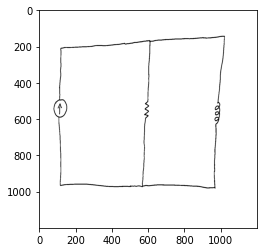

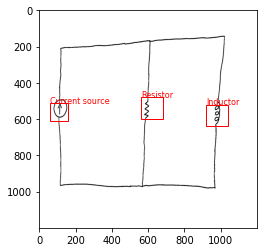

In [82]:
plt.imshow(simImage, cmap = 'gray')
plt.show()
drawBoxes(simImage,boxes_newH, classes_newH)

In [97]:
b, c = sortLtoR(boxes_newH, classes_newH)
s = HSPICE(dictionary, c, values)
print(s)

Current source
Resistor
Inductor

I1 HIGH GND ac 1
R1 HIGH GND 10k
L1 HIGH GND 1
.option post brief nomod 
.ac dec 100 1 10G 
.end
